## Playing around with flows

This notebook shows some first steps using flows.

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0-rc0
TF  Version 2.0.0-rc0


In [3]:
if False:
    tfk = tf.keras
    tfkl = tf.keras.layers

    n = 2000
    x2 = np.random.randn(n).astype(dtype=np.float32) * 2.
    x1 = np.random.randn(n).astype(dtype=np.float32) + (x2 * x2 / 4.)
    data = np.stack([x1, x2], axis=-1)
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10, 10])
    distribution = tfd.TransformedDistribution(
      distribution=tfd.Normal(loc=0., scale=1.),
      bijector=tfb.MaskedAutoregressiveFlow(
          lambda x: tf.unstack(made(x), num=2, axis=-1)),
      event_shape=[2])
    # Construct and fit model.
    x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(x_)
    model = tfk.Model(x_, log_prob_)
    model.compile(optimizer=tf.optimizers.Adam(),
                loss=lambda _, log_prob: -log_prob)
    batch_size = 25
    model.fit(x=data,
            y=np.zeros((n, 0), dtype=np.float32),
            batch_size=batch_size,
            epochs=100,
            steps_per_epoch=1,  # Usually `n // batch_size`.
            shuffle=True,
            verbose=False)
    # Use the fitted distribution.
    distribution.sample((3, 1))
    distribution.log_prob(np.ones((3, 2), dtype=np.float32))

### Change of variables numerical

 

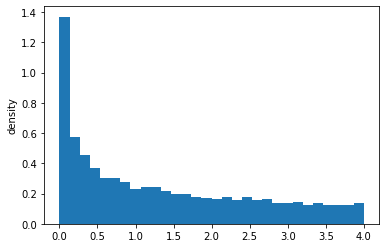

In [4]:
N = 10000
d = tfd.Uniform(low=0, high=2)
zs = d.sample(N)
x = zs**2

plt.hist(x, density=True, bins=30)
plt.ylabel('density')
plt.show()

### The Bijector package tfp.bijectors

Let's take the square as a bijector

z -- f(z)=z^2 --> x

In [5]:
f = tfb.Square() # This is a bijector
f.forward(2.0) #4
f.inverse(4.0) #2

<tf.Tensor: id=33, shape=(), dtype=float32, numpy=2.0>

Let's use the uniform distribution as a base transformation 

In [6]:
base_dist = tfd.Uniform(0.0,2.0)
mydist = tfd.TransformedDistribution(distribution=base_dist, bijector=f)

In [7]:
mydist.prob(3)

<tf.Tensor: id=80, shape=(), dtype=float32, numpy=0.14433756>

(0, 1)

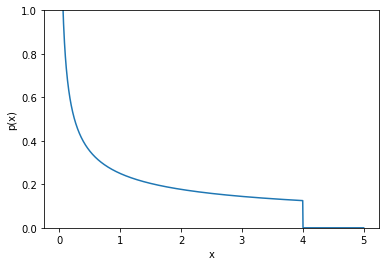

In [8]:
xs = np.linspace(0.001, 5,1000)
ps = mydist.prob(xs)
plt.plot(xs,ps)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.ylim(0,1)

### Using several bijectors

In [9]:
chain = tfb.Chain([tfb.Square(), tfb.Square()], name="x4")
chain.forward(2.0)

<tf.Tensor: id=148, shape=(), dtype=float32, numpy=16.0>

### Training Bijectors

An extremly simple example, to go from a $N(0,1)$ Gaussian to a $N(5.0,0.2)$ Gaussian. Let's sample some training data of our traget distribution:

(1000, 1)

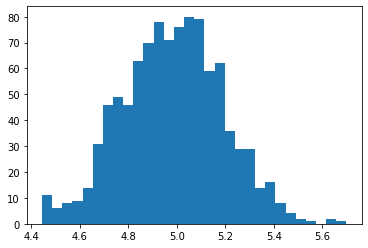

In [117]:
N = 1000
X = tfd.Normal(loc=5,scale=0.2).sample(1000)
X = X.numpy().reshape([N,1])
plt.hist(X,30)
X.shape

Building the flow using an Affine transformation. Simply shift and scale something.

In [118]:
#Making a distribution using the flow and a N(0,1)
shift = tf.Variable(0.0)
scale=tf.Variable(1.0)
bijector = tfb.AffineScalar(shift=shift, scale=scale)
dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0,scale=1),bijector=bijector)

In [119]:
-tf.reduce_mean(dist.log_prob(X)) #The NLL

<tf.Tensor: id=11888878, shape=(), dtype=float32, numpy=13.350883>

### Training in eager mode

In [120]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1) #quite high lr for normalizing flows.

for i in range(1000):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) 
        gradients = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dist.trainable_variables))
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start), " shift ", shift.numpy(), " scale ", scale.numpy())
        start = time()

0   13.350883 303.7178604602814  shift  0.099999934  scale  1.1
100   1.9068459 0.5031766891479492  shift  3.977317  scale  2.443628
200   0.16280347 0.5105490684509277  shift  4.9811068  scale  0.36111793
300   -0.15560193 0.47665882110595703  shift  4.9820414  scale  0.20721465
400   -0.15560779 0.4687938690185547  shift  4.982067  scale  0.20710315
500   -0.15560779 0.47071194648742676  shift  4.9820676  scale  0.20710143
600   -0.15560772 0.4700429439544678  shift  4.982067  scale  0.20710145
700   -0.1556077 0.4746968746185303  shift  4.9820676  scale  0.20710145
800   -0.15560772 0.47537899017333984  shift  4.982067  scale  0.20710145
900   -0.1556077 0.47272419929504395  shift  4.9820676  scale  0.20710145


(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.20710145>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.982067>)

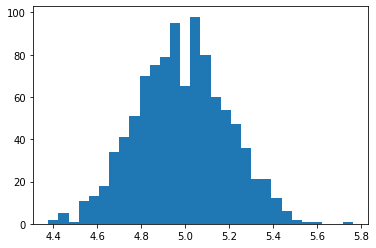

In [121]:
XX = dist.sample(1000)
XX = XX.numpy().reshape([N,1])
plt.hist(XX,30)
dist.trainable_variables

# ====== Below is Keras Code which is not really working (yet) ====

### Defining a trainable keras model using the 

In [11]:
class Affine(tf.keras.models.Model):

    def __init__(self, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        # Defining the flow
        bijectors=[]
        for i in range(2): #Number of repeats
            bijectors.append(tfb.AffineScalar(shift=tf.Variable(0.0), scale=tf.Variable(1.0)))
            bijectors.append(LeakyReLU(tf.Variable(0.5)))
        bijector = tfb.Chain(bijectors)
        dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0,scale=1),bijector=bijector)
        self.flow = dist
        
    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)

    def getFlow(self, num):
        return self.flow.sample(num)

In [12]:
model = Affine()
# model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
model.summary()

Model: "affine"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


### Defining a trainable keras model using the functional API

In [50]:
x_ = tf.keras.Input(shape=(1,), dtype=tf.float32)
log_prob_ = dist.log_prob(x_)
model = tf.keras.Model(x_, log_prob_)
#The loss is called with the arguments: y_true, y_pred (see tf.losses.Loss())
#In our case y_pred is log(z)  
model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob) 
_ = model(X) 
#model.summary() no trainable weights

In [51]:
model.fit(x=X,
            y=np.zeros((N, 0), dtype=np.float32),
            batch_size=128,
            shuffle=True,
            verbose=True,
            epochs=1)

Train on 1000 samples
1000/1000 [==============================] - 0s 164us/sample - loss: -25.1077


In [1]:
# quite easy to interpret - multiplying by alpha causes a contraction in volume.
class LeakyReLU(tfb.Bijector):
    def __init__(self, alpha=0.5, beta=1.1,validate_args=False, name="leaky_relu"):
        super(LeakyReLU, self).__init__(forward_min_event_ndims=0)
        self.alpha = alpha
        self.beta = beta

    def _forward(self, z):
        return tf.where(tf.greater_equal(z, 0), self.beta*z, self.alpha * z)

    def _inverse(self, x):
        return tf.where(tf.greater_equal(x, 0), x/self.beta, x / self.alpha * x)

    def _inverse_log_det_jacobian(self, x):
        I = tf.ones_like(x)
        J_inv = tf.where(tf.greater_equal(x, 0), 1.0 / self.beta * I, 1.0 / self.alpha * I)
        # abs is actually redundant here, since this det Jacobian is > 0
        log_abs_det_J_inv = tf.math.log(tf.abs(J_inv))
        return tf.reduce_sum(log_abs_det_J_inv, axis=0)

NameError: name 'tfb' is not defined